In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
# Add the project root directory (not src) to sys.path
sys.path.append(os.path.abspath("../src/data/"))


clean = '../data/CLEAN'


Cofounder : "Box office" refers to total ticket sale revenues, and doesn't include revenues from streaming/VoD/etc. (which could be any amount and are usually unknown). 

0. 1991-2020 pour FBI data, ... pour GVD data
1. stantardiser les box-office 
2. plot les films au cours des années qui ont un box office au-dessus de la médianne
3. plot le genre qui ont le plus de box office 
4. plot le genre qui est le plus représenté dans les violent data (piechart)
5. plot les categories qui le plus représenté dans les violent data (piechart)
6. extract the words the most said in the summaries of the violent data 
7. plot the occurences of the words in the violent data 
8. Trouver unemployment data
9. Visualiser throughout the years real data (GVD, FBI)

# Preprocessing 

In [74]:
# Save the DataFrame to a CSV file for the autoregressive model
Violent_Movies_autoregressive = pd.read_csv('../../data/CLEAN/Violent_Movies_final.tsv', sep="\t")
Movies_autoregressive = pd.read_csv('../../data/CLEAN/Non_zero_Violent_Movies.tsv', sep="\t")
#Kaggle_movies_metadata = pd.read_csv('../../data/CLEAN/Kaggle_movies_metadata_final.tsv', sep="\t")


In [75]:
Movies_autoregressive.sort_values(by=['Year', 'Week'], inplace=True)
Movies_autoregressive = Movies_autoregressive[Movies_autoregressive["Year"] >1992]
Movies_autoregressive[["Movie name","Box office revenue","Year"]].to_csv('../../data/CLEAN/Movies_box_office_yearly.tsv', sep="\t", index=False)

TODO The loaded data must have no nan (fill with 0), corrspond to the years of the FBI

In [36]:
# Sort by year and week to ease further analysis 
Violent_Movies_autoregressive.sort_values(by=['Year', 'Week'], inplace=True)
# We are interested at non-zero box office revenue for visualisation purposes
Non_zero_Violent_Movies =Violent_Movies_autoregressive[Violent_Movies_autoregressive["Box office revenue"].notnull()]

In [37]:
Years_violent_movies = Violent_Movies_autoregressive.Year.unique()
Years_w_box_office = Non_zero_Violent_Movies.Year.unique()
print("The range of years for the violent movies that have a box office value is from {} to {}.".format(Years_w_box_office[0], Years_w_box_office[-1]))
print("The range of years that we have violent movies is from {} to {}.".format(Years_violent_movies[0], Years_violent_movies[-1]))

The range of years for the violent movies that have a box office value is from 1913 to 2012.
The range of years that we have violent movies is from 1901 to 2018.


We decided to handle this difference of range with two approaches: 

- Considering only the movies that we have the box office value (First tests)
- Inputing the median of all box offices over the full period to the nan value (Jade)
- Inputing the rolling median over the number of weeks considered by our ARLD model as maximum (TODO)

Note that we tried to fill the missing values with the Kaggle Dataset as we did for the dates but disparities between the two datasets could be observed and thus the decision was made to stick only to CMU data to avoid creating inconsistencies and errors. 

Here is the attempt of filling with Kaggle dataset : 

Run only if load kaggle dataset

In [38]:
kaggle_data = False 
if kaggle_data:
#iter on all dataset whethever having the value of box-office or not 

    movie_w_box_office = Violent_Movies_autoregressive.copy()

    counter_same = 0
    counter_multiple = 0
    counter_stay_same = 0
    counter_diff = 0 
    counter_less_than_1 = 0
    counter_save = 0
    counter_nothing = 0
    diff_revenue = pd.DataFrame(columns=["Title","CMU_revenue", "Kaggle_revenue", "Diff","Percentage"])


    for index, row in Violent_Movies_autoregressive.iterrows() :
        # is it in the kaggle dataset ?
        kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
        
        if kaggle_data.empty :
            if Violent_Movies_autoregressive.loc[index, "Box office revenue"]!= 0:
                counter_stay_same += 1
            else: 
                counter_nothing += 1
                movie_w_box_office.drop([index], inplace=True)

        #if yes and only ones 
        elif kaggle_data.shape[0] == 1 :

            if (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
                if  kaggle_data.iloc[0]["revenue"] == Violent_Movies_autoregressive.loc[index, "Box office revenue"]: 
                    counter_same += 1
                    #print("Revenue matched :) ")
            

                else: 
                    Percentage_diff = np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"])/(kaggle_data.iloc[0]["revenue"]+Violent_Movies_autoregressive.loc[index, "Box office revenue"])
                    new_row = pd.DataFrame({"Title": [row["Movie name"]], "CMU_revenue": [Violent_Movies_autoregressive.loc[index, "Box office revenue"]],"Kaggle_revenue":[kaggle_data.iloc[0]["revenue"]], "Diff": np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"]), "Percentage": Percentage_diff})
                    diff_revenue = pd.concat([diff_revenue, new_row], ignore_index=True)
                    counter_diff += 1
                    if Percentage_diff < 0.2:
                        counter_less_than_1 += 1
                        print("Catch up in extremis")
                        Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
                    else: 
                        movie_w_box_office.drop([index], inplace=True)

            elif (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] == 0):
                counter_save += 1
                print("Save by kaggle")
                Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
            elif(kaggle_data.iloc[0]["revenue"] == 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] == 0):
                counter_nothing += 1
                movie_w_box_office.drop([index], inplace=True)
            
            elif(kaggle_data.iloc[0]["revenue"] == 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
                counter_stay_same += 1

                


        else: #if multiple movies have this name in the kaggle dataset, compare with the incomplete date of the CMU dataset
            counter_multiple += 1
            date = Violent_Movies_autoregressive.loc[index, "Release date"]
            #if not the same year and not the year in the CMU, drop
            if pd.isna(date) or len(date) < 4 :
                movie_w_box_office.drop([index], inplace=True).drop([index],inplace=True)

            #  else, compare
            else :
                kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]
            #found only 1 movie this year ? extract the date !
                if kaggle_data.shape[0] == 1 :
                    if ( kaggle_data.iloc[0]["revenue"] == Violent_Movies_autoregressive.loc[index, "Box office revenue"]) and (kaggle_data.iloc[0]["revenue"] != 0): 
                        counter_same += 1
                    elif ( kaggle_data.iloc[0]["revenue"] != Violent_Movies_autoregressive.loc[index, "Box office revenue"]): 
                        if (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
                            counter_diff += 1
                            Percentage_diff = np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"])/(kaggle_data.iloc[0]["revenue"]+Violent_Movies_autoregressive.loc[index, "Box office revenue"])
                            new_row = pd.DataFrame({"Title": [row["Movie name"]], "CMU_revenue": [Violent_Movies_autoregressive.loc[index, "Box office revenue"]],"Kaggle_revenue":[kaggle_data.iloc[0]["revenue"]], "Diff": np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"]), "Percentage": Percentage_diff})
                            diff_revenue = pd.concat([diff_revenue, new_row], ignore_index=True)
                            if Percentage_diff < 0.2:
                                counter_less_than_1 += 1
                                print("Catch up in extremis")
                                Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
                            else: 
                                movie_w_box_office.drop([index], inplace=True)
                        elif (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] == 0):
                            counter_save += 1
                            print("Save by kaggle")
                            Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
                            
                        elif(kaggle_data.iloc[0]["revenue"] == 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
                            counter_stay_same += 1
                    else:
                        counter_nothing += 1
                        movie_w_box_office.drop([index], inplace=True)
                else: 
                    counter_nothing += 1
                    movie_w_box_office.drop([index], inplace=True)
                    


In [39]:
if kaggle_data: 
    print("There are {} movies that have less than 1 percents difference".format(counter_less_than_1))
    print("There are {} matching revenues".format(counter_same))   
    print("There are {} mismatched revenues, there is a difference between kaggle and cmu".format(counter_diff))
    print("There are {} unmatch revenues because multiple countries have same title".format(counter_multiple))
    print("There are {} movies that stay the same ".format(counter_stay_same))
    print("There are {} movies that we have the information".format(counter_same+counter_stay_same))
    print("There are {} movies that we have the information taking into account 1 percents difference".format(counter_same+counter_stay_same+counter_less_than_1))
    print("There are {} violent movies in total".format(len(Violent_Movies_autoregressive)))
    print("We can save {} movies".format(counter_save))
    print("There are {} movies that we can save".format(counter_save+counter_same+counter_stay_same+counter_less_than_1))
    print("It correspond to {:%} percentage of violent movies".format((counter_save+counter_same+counter_stay_same+counter_less_than_1)/len(Violent_Movies_autoregressive)))
    print("All the counters {}".format(counter_save+counter_same+counter_stay_same+counter_diff+counter_nothing))
    print("If we don't consider Kaggle dataset and only stick to the CMU one we have {:%} movies retained from the original dataset".format(len(Non_zero_Violent_Movies)/ len(Violent_Movies_autoregressive)*100))

Here is the different stantardisation and filling tested: 

In [40]:
def normalise_box_office(extracted_data,window_size=6):

    rolling_mean = extracted_data["Box office revenue"].rolling(window=window_size, min_periods=1).mean()
    rolling_std = extracted_data["Box office revenue"].rolling(window=window_size, min_periods=1).std().fillna(1) # avoid division by 0 and enable to have 0 as z-score since z-score not applicable in that case
    extracted_data.loc[:, 'z_score'] = (extracted_data["Box office revenue"] - rolling_mean ) / rolling_std

    return extracted_data

In [41]:
def box_office_extracted(data,year,start_week,stop_week,ratio=False, normalised=False, window_size =6): 
    extracted_data = data[(data.Year==year) & (data.Week >=start_week) & (data.Week <=stop_week)]
   
    if normalised:
        extracted_data = normalise_box_office(extracted_data,window_size)
    else:
        extracted_data = extracted_data

    return extracted_data

In [42]:
def aggregated_box_office(data,year, start_week, stop_week, ratio=False, normalised=False, window_size =6):
    extracted_data = box_office_extracted(data,year, start_week, stop_week, ratio, normalised, window_size)
    Violent_movie_metric = extracted_data.groupby(['Year', 'Week'])["Box office revenue"].sum()
    result_df = Violent_movie_metric.reset_index(name='Aggregated box office revenue')
    if ratio: 
        count_of_movies = extracted_data.groupby(['Year', 'Week']).size()
        divider = count_of_movies.reset_index(name='Movie_counts')
        result_df.loc[:, "Box office ratio"] = result_df["Aggregated box office revenue"]/divider["Movie_counts"] # Ensure that the box office revenue is divided by the number of movies in the dataset and hence comparable accross week/years
    return result_df

In [43]:
aggregated_box_office(Violent_Movies_autoregressive,2019,1,52, ratio=True, normalised=False)

,Year,Week,Aggregated box office revenue,Box office ratio


In [44]:
# Example of use  
test = aggregated_box_office(Violent_Movies_autoregressive,2008,1,4,ratio=False, normalised=True)
#test.to_csv(clean+"/movie_violence_metric.csv")
test

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_54717/3631935430.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_data.loc[:, 'z_score'] = (extracted_data["Box office revenue"] - rolling_mean ) / rolling_std


,Year,Week,Aggregated box office revenue
0,2008,1,45847751.0
1,2008,2,13097915.0
2,2008,3,231798151.0
3,2008,4,254553424.0


# Plots 

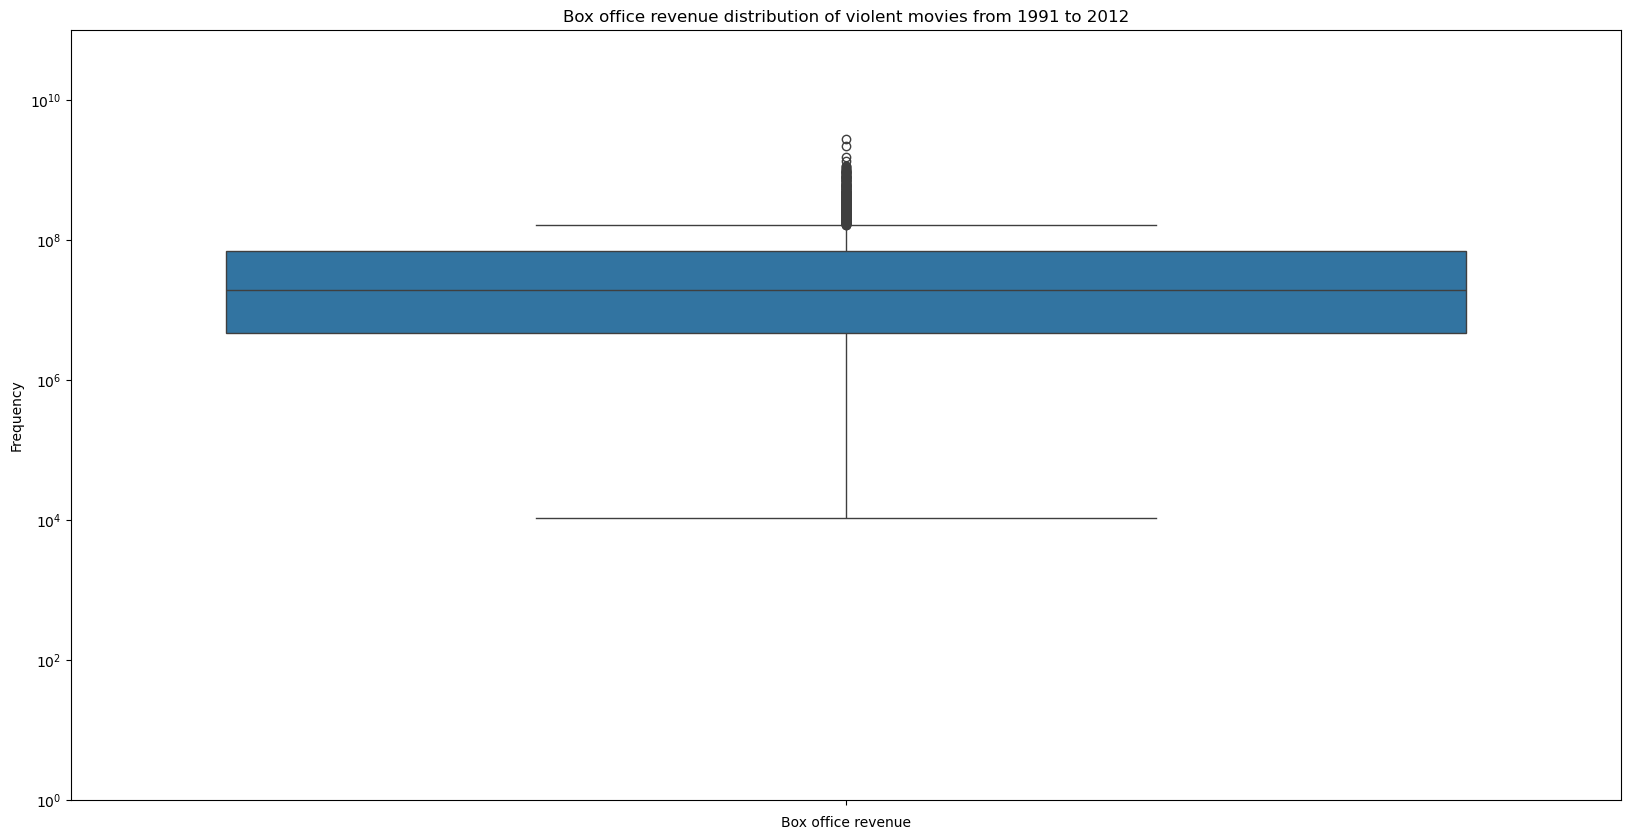

In [45]:
# Plot on all the years and movies to obtain a first glimpse of the data
plt.figure(figsize=(20,10))
sns.boxplot(data=Non_zero_Violent_Movies["Box office revenue"])
plt.xlabel('Box office revenue')
plt.ylabel('Frequency')
plt.title('Box office revenue distribution of violent movies from 1991 to 2012')
plt.yscale('log')
plt.ylim(1, 1e11)
plt.show()

In [46]:
Non_zero_Violent_Movies.sort_values(by="Year", inplace=True)
Non_zero_Violent_Movies_match_FBI = Non_zero_Violent_Movies[Non_zero_Violent_Movies["Year"] > 1991]


/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_54717/1898916857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_zero_Violent_Movies.sort_values(by="Year", inplace=True)


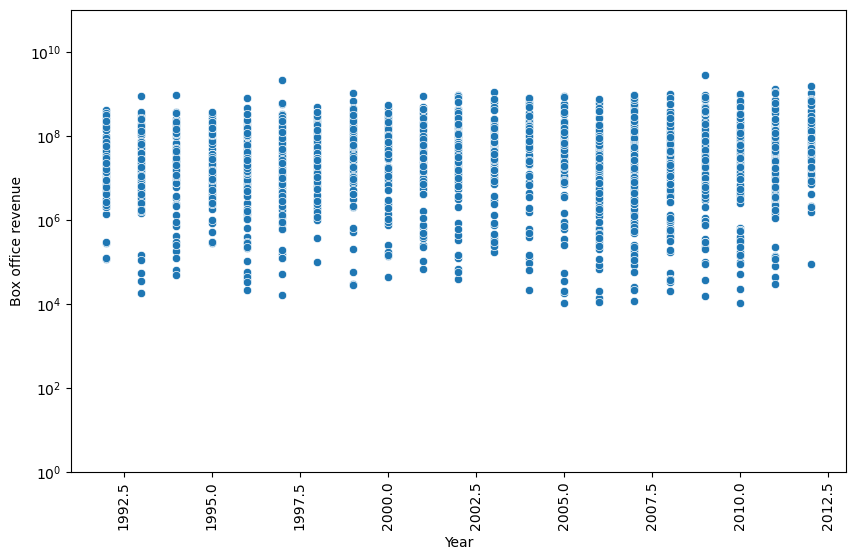

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Non_zero_Violent_Movies_match_FBI, x="Year", y="Box office revenue")
plt.yscale('log')
plt.ylim(1, 1e11)
# Rotating X-axis labels
plt.xticks(rotation = 90)
plt.show()

<Figure size 1000x600 with 0 Axes>

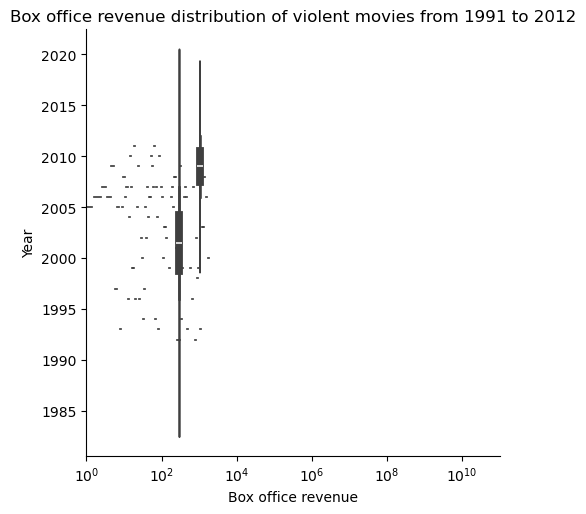

In [48]:
# Plot the distribution of box office revenue for violent movies from 1991 to 2012

# With Violin plot
plt.figure(figsize=(10, 6))
sns.catplot(
    data=Non_zero_Violent_Movies_match_FBI, x="Box office revenue", y="Year", kind="violin",
)
plt.xscale('log')
plt.xlim(1, 1e11)
plt.title('Box office revenue distribution of violent movies from 1991 to 2012')
plt.show()

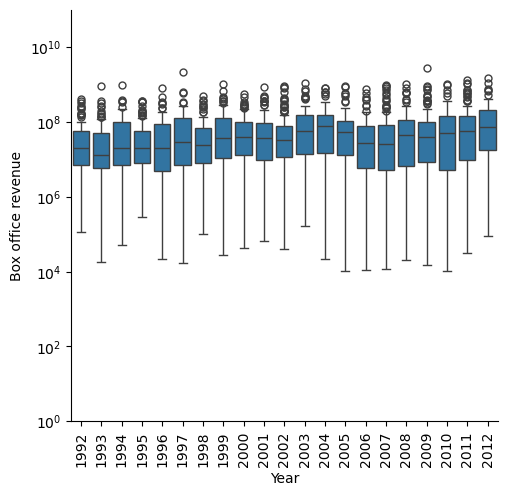

In [49]:
# With Box plot
sns.catplot(data=Non_zero_Violent_Movies_match_FBI, y="Box office revenue", x="Year", kind="box")
plt.yscale('log')
# Rotating X-axis labels
plt.xticks(rotation = 90)
plt.ylim(1, 1e11)
plt.show()


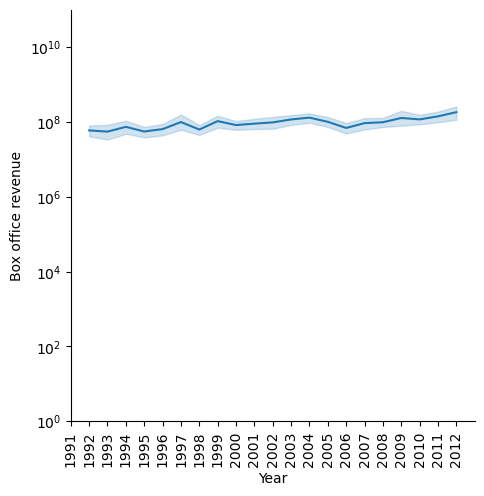

In [50]:
# With Line plot
sns.relplot(data=Non_zero_Violent_Movies_match_FBI, x="Year", y="Box office revenue", kind="line")
plt.xticks(rotation = 90)
plt.yscale('log')
plt.ylim(1, 1e11)
plt.xticks(np.arange(1991, 2013, 1))
plt.show()

Let's look more into 2008

In [51]:
# Filter data for the specified year
Year = 2008
box_off_agg = Non_zero_Violent_Movies_match_FBI[Non_zero_Violent_Movies_match_FBI.Year == Year].groupby("Week")["Box office revenue"].sum().copy()
box_off_agg = box_off_agg.reset_index(name='Box_off_agg')
result_df = Non_zero_Violent_Movies_match_FBI[Non_zero_Violent_Movies_match_FBI.Year == 2008].groupby("Week").size()
result_df = result_df.reset_index(name='count_of_movies')
merged_df = box_off_agg.merge(
    result_df, on="Week", how="left"
)



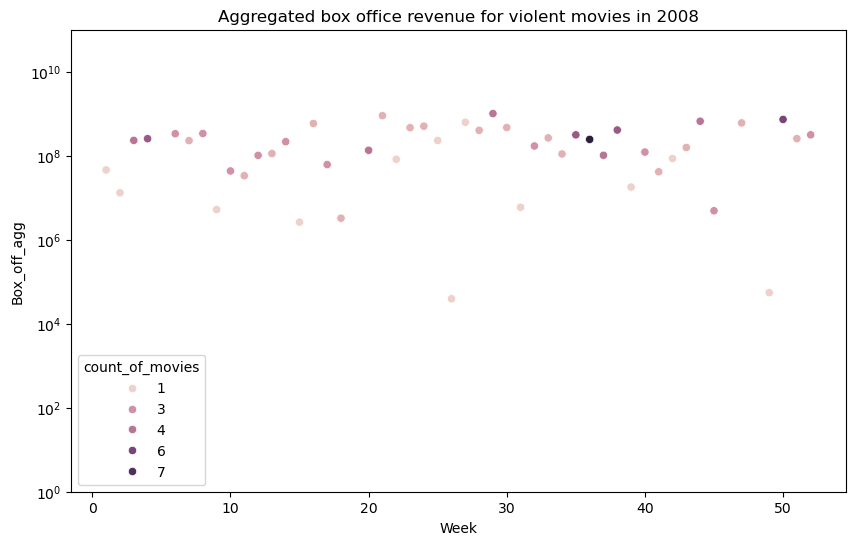

In [52]:
# Plot the aggregated box office revenue for violent movies in 2008 with colour representing the number of movies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="Week", y="Box_off_agg", hue="count_of_movies")
plt.yscale('log')
plt.ylim(1, 1e11)
plt.title('Aggregated box office revenue for violent movies in 2008')
plt.show()


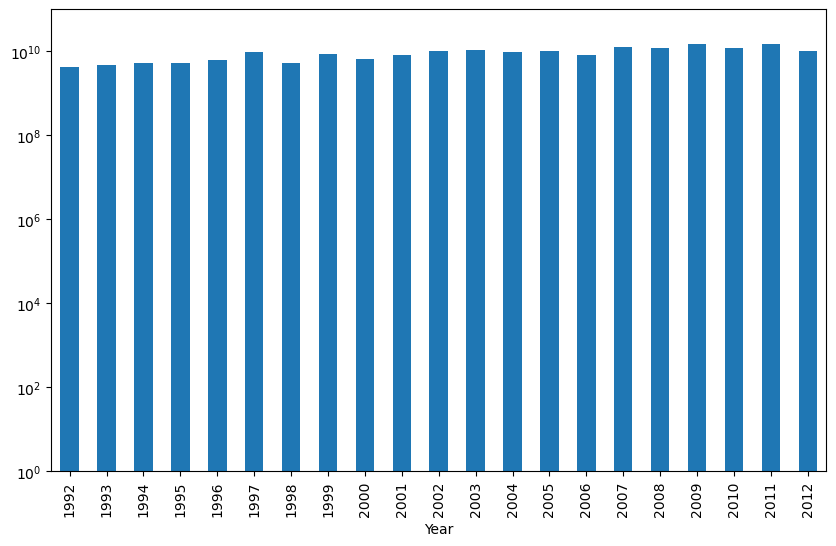

In [53]:
plt.figure(figsize=(10, 6))
Non_zero_Violent_Movies_match_FBI.groupby("Year")["Box office revenue"].sum().plot(kind="bar",logy=True)
plt.ylim(1, 1e11)
plt.show()

In [54]:
year = 2008
start_week = 1
stop_week = 52
data=  Non_zero_Violent_Movies_match_FBI

extracted_data = data[(data.Year==year) & (data.Week >=start_week) & (data.Week <=stop_week)]
#extracted_data["Box office revenue"]/extracted_data.groupby(['Year', 'Week']).size()
count_of_movies = extracted_data.groupby(['Year', 'Week']).size()
result_df = count_of_movies.reset_index(name='Movie_counts')
result_df["Movie_counts"]
extracted_data["Box office revenue"]

4767    40779241.0
7345    49230772.0
7549    25739015.0
7953      636246.0
8119    27641569.0
           ...    
5681     2674090.0
6035      580862.0
1122    11125849.0
2988    20031211.0
5639      321820.0
Name: Box office revenue, Length: 123, dtype: float64

In [55]:
data =aggregated_box_office(Non_zero_Violent_Movies_match_FBI,2008,1,4,ratio=False, normalised=True)
data

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_54717/3631935430.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_data.loc[:, 'z_score'] = (extracted_data["Box office revenue"] - rolling_mean ) / rolling_std


,Year,Week,Aggregated box office revenue
0,2008,1,45847751.0
1,2008,2,13097915.0
2,2008,3,231798151.0
3,2008,4,254553424.0


In [56]:
Non_zero_Violent_Movies_match_FBI.head()

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week
2990,1238102,Bad Lieutenant,1992-09-16,2019469.0,1992,38
8167,872342,Praying with Anger,1992-09-12,1400000.0,1992,37
6380,1256990,Candyman,1992-09-11,25792310.0,1992,37
4558,5112836,Guncrazy,1992-09-11,114516.0,1992,37
4539,3745331,Hellraiser III: Hell on Earth,1992-09-11,12525537.0,1992,37


In [58]:
# Save the data for the violin plot
Non_zero_Violent_Movies_match_FBI[["Movie name","Box office revenue","Box office revenue","Year"]].to_csv('../../data/CLEAN/Violent_Movies_box_office_yearly.tsv', sep="\t", index=False)

In [59]:
Violent_movie_box_office_date_week = Non_zero_Violent_Movies_match_FBI.groupby(["Year","Week"])["Box office revenue"].sum()

In [76]:
Matrix_violence = pd.DataFrame(Violent_movie_box_office_date_week).unstack(level=0).fillna(0)
Matrix_violence.head()

Box office revenue                                                  \
Year               1992         1993       1994        1995        1996   
Week                                                                      
1                   0.0    8669487.0        0.0  26325256.0         0.0   
2                   0.0  102198374.0  3662459.0  59390961.0  46986704.0   
3            50944029.0          0.0        0.0  21056783.0  26059175.0   
4            38091750.0   25975639.0        0.0         0.0   5711695.0   
5            43838238.0  154660386.0        0.0  11986234.0  22754725.0   

                                                                     ...  \
Year        1997        1998         1999         2000         2001  ...   
Week                                                                 ...   
1     17445351.0         0.0          0.0          0.0  207515725.0  ...   
2     45494843.0         0.0   96963543.0   74655409.0   18195610.0  ...   
3     38012241.0  83955701.0    4197729.0   34266564.0   80187321.0  ...   
4      7233324.0  15985576.0  248639099.0   21672714.0   25993939.0  ...   
5      3433056.0  80503229.0  161626121.0  161834276.0   40908201.0  ...   

                                                                      \
Year         2003         2004         2005         2006        2007   
Week                                                                   
1             0.0          0.0  147877985.0    9380029.0         0.0   
2      88929111.0          0.0    8484198.0   28047963.0  85597734.0   
3      50435123.0   13220394.0  155962678.0  270192158.0  49919485.0   
4     148680420.0  203560858.0  141322703.0  275737778.0  93759211.0   
5     202260493.0   63545989.0  118063972.0   67185148.0         0.0   

                                                                       
Year         2008         2009         2010         2011         2012  
Week                                                                   
1      45847751.0          0.0          0.0          0.0          0.0  
2      13097915.0   76514050.0  314636591.0  227817248.0   96262212.0  
3     231798151.0  226546703.0  186598803.0   21144800.0  182033284.0  
4     254553424.0   98209354.0  223758487.0   96047633.0  123499520.0  
5             0.0  317559240.0   52826594.0  150597171.0          0.0  

[5 rows x 21 columns]

In [61]:
# Save the data for the histogram plot
Matrix_violence.to_csv('../../data/CLEAN/Violent_Movies_box_office_weekly.tsv', sep="\t", index=False)



In [112]:
MT= Movies_autoregressive[["Movie name","Box office revenue","Year"]]
MV = Non_zero_Violent_Movies_match_FBI[["Movie name","Box office revenue","Year"]]

In [113]:
MT['Year-Type'] = MT.Year.apply(lambda s: str(s) + " Total")
MT['class'] = "All"
MV['Year-Type'] = MV.Year.apply(lambda s: str(s) + " Violent")
MV['class'] = "Violent"

/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_54717/2850754237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MT['Year-Type'] = MT.Year.apply(lambda s: str(s) + " Total")
/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_54717/2850754237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MT['class'] = "All"
/var/folders/2y/_yhdrpzj5kb7clnr0qc0chxc0000gn/T/ipykernel_54717/2850754237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [114]:
For_Flourish= pd.concat([MV,MT])

In [115]:
For_Flourish.sort_values(by=['Year-Type'], inplace=True)

In [116]:
For_Flourish.to_csv('../../data/CLEAN/ALL_box_office_years.tsv', sep="\t", index=False)

In [119]:
Non_zero_Violent_Movies_match_FBI["Box office revenue"].max()

2782275172.0